# Chest X-Ray Disease Classification

Train a ResNet50 model to classify 15 different chest disease categories from the NIH Chest X-Ray dataset.

## Dataset
- 31,416 chest X-ray images
- Split: 21,991 train / 4,712 validation / 4,713 test
- 15 disease classes

## Model
- Architecture: ResNet50 pretrained on ImageNet
- Optimizer: Adam with learning rate 0.001
- Scheduler: ReduceLROnPlateau
- Data augmentation: horizontal flip, rotation, color jitter

## Results
- Best validation accuracy: 37% after 20 epochs
- Model saved as best_resnet50.pth
- Confusion matrix visualization included

In [16]:
# ------------------------------------------------------------------------------
# IMPORTS
# Load required libraries for PyTorch training and evaluation
# ------------------------------------------------------------------------------

import os 
import json
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

In [17]:
# ------------------------------------------------------------------------------
# DATASET CLASS
# Custom PyTorch dataset for loading chest X-ray images
# ------------------------------------------------------------------------------

class ChestXrayDataset(Dataset):
    """Dataset for NIH Chest X-ray with 15 disease classes"""
    
    def __init__(self, root_dir, transform=None, cache_images=True):
        self.root_dir = root_dir 
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.cache_images = cache_images
        self.cached_data = {}

        # Get all class folders (15 disease categories)
        class_folders = sorted(os.listdir(root_dir))
        
        for class_idx, class_name in enumerate(class_folders):
            class_dir = os.path.join(root_dir, class_name)
            
            if not os.path.isdir(class_dir):
                continue
            
            # Collect all images in this class folder
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.png'):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)
        
        # Preload images into memory for faster training
        if self.cache_images:
            print(f"Caching {len(self.image_paths)} images in memory...")
            for idx in range(len(self.image_paths)):
                img_path = self.image_paths[idx]
                image = Image.open(img_path).convert('RGB')
                self.cached_data[idx] = image
            print(f"✓ Cached {len(self.cached_data)} images")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx): 
        # Load from cache if available, otherwise from disk
        if self.cache_images and idx in self.cached_data:
            image = self.cached_data[idx].copy()
        else:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
        
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [18]:
# ------------------------------------------------------------------------------
# LOAD DATA & TRANSFORMS
# Load class mapping and create train/val/test datasets with transforms
# ------------------------------------------------------------------------------

# Load class mapping
with open('data/class_mapping.json', 'r') as f:
    class_mapping = json.load(f)
    class_mapping = {int(k): v for k, v in class_mapping.items()}

NUM_CLASSES = len(class_mapping)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {list(class_mapping.values())}")

# Data transforms with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip X-rays horizontally
    transforms.RandomRotation(degrees=10),    # Slight rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard transforms for validation/test (no augmentation)
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ChestXrayDataset(root_dir='data/train', transform=train_transform, cache_images=False)
val_dataset = ChestXrayDataset(root_dir='data/val', transform=eval_transform, cache_images=False)
test_dataset = ChestXrayDataset(root_dir='data/test', transform=eval_transform, cache_images=False)

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset):,} images")
print(f"Val:   {len(val_dataset):,} images")
print(f"Test:  {len(test_dataset):,} images")

Number of classes: 15
Classes: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Dataset sizes:
Train: 21,287 images
Val:   4,664 images
Test:  4,679 images


In [19]:
# ------------------------------------------------------------------------------
# MODEL SETUP
# Create DataLoaders and initialize ResNet50 with GPU acceleration
# ------------------------------------------------------------------------------

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    torch.backends.cudnn.benchmark = True  # Speed optimization

# Model: ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

print(f"\nModel: ResNet50")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cuda
GPU: NVIDIA GeForce RTX 4080
GPU Memory: 17.17 GB

Model: ResNet50
Total parameters: 23,538,767


In [ ]:
# ------------------------------------------------------------------------------
# TRAINING LOOP
# Train ResNet50 for 20 epochs with validation and best model checkpointing
# ------------------------------------------------------------------------------

num_epochs = 20
best_val_acc = 0.0

print("\nStarting training...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (batch_idx + 1) % 50 == 0:  # Print progress every 50 batches
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Acc: {val_acc:.2f}%")
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet50.pth')
        print(f"Saved best model (val_acc: {val_acc:.2f}%)")

print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")


Starting training...

Epoch 1/20
  Batch [10/167], Loss: 2.3314
  Batch [10/167], Loss: 2.3314
  Batch [20/167], Loss: 2.3298
  Batch [20/167], Loss: 2.3298
  Batch [30/167], Loss: 2.3277
  Batch [30/167], Loss: 2.3277
  Batch [40/167], Loss: 2.5433
  Batch [40/167], Loss: 2.5433
  Batch [50/167], Loss: 2.2894
  Batch [50/167], Loss: 2.2894
  Batch [60/167], Loss: 2.3238
  Batch [60/167], Loss: 2.3238
  Batch [70/167], Loss: 2.4202
  Batch [70/167], Loss: 2.4202
  Batch [80/167], Loss: 2.2711
  Batch [80/167], Loss: 2.2711
  Batch [90/167], Loss: 2.3392
  Batch [90/167], Loss: 2.3392
  Batch [100/167], Loss: 2.1297
  Batch [100/167], Loss: 2.1297
  Batch [110/167], Loss: 2.3071
  Batch [110/167], Loss: 2.3071
  Batch [120/167], Loss: 2.4578
  Batch [120/167], Loss: 2.4578
  Batch [130/167], Loss: 2.3812
  Batch [130/167], Loss: 2.3812
  Batch [140/167], Loss: 2.3681
  Batch [140/167], Loss: 2.3681
  Batch [150/167], Loss: 2.2734
  Batch [150/167], Loss: 2.2734
  Batch [160/167], Loss:

In [20]:
# ------------------------------------------------------------------------------
# TEST EVALUATION
# Load best model and evaluate on test set with per-class accuracy
# ------------------------------------------------------------------------------

# Load best model
model.load_state_dict(torch.load('best_resnet50.pth'))
model.eval()

test_labels = []
test_preds = []

print("\nEvaluating on test set...")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i in range(NUM_CLASSES):
    class_mask = np.array(test_labels) == i
    if class_mask.sum() > 0:
        class_acc = accuracy_score(
            np.array(test_labels)[class_mask],
            np.array(test_preds)[class_mask]
        )
        print(f"  {class_mapping[i]:25} - {class_acc*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)


Evaluating on test set...

Test Accuracy: 37.00%

Per-Class Accuracy:
  Atelectasis               - 48.03%
  Cardiomegaly              - 46.95%
  Consolidation             - 3.05%
  Edema                     - 12.77%
  Effusion                  - 62.06%
  Emphysema                 - 29.10%
  Fibrosis                  - 6.42%
  Hernia                    - 25.00%
  Infiltration              - 26.07%
  Mass                      - 41.43%
  No Finding                - 41.34%
  Nodule                    - 33.99%
  Pleural_Thickening        - 3.55%
  Pneumonia                 - 0.00%
  Pneumothorax              - 42.86%

Test Accuracy: 37.00%

Per-Class Accuracy:
  Atelectasis               - 48.03%
  Cardiomegaly              - 46.95%
  Consolidation             - 3.05%
  Edema                     - 12.77%
  Effusion                  - 62.06%
  Emphysema                 - 29.10%
  Fibrosis                  - 6.42%
  Hernia                    - 25.00%
  Infiltration              - 26.07%
  M


Confusion matrix saved to 'confusion_matrix_resnet50.png'


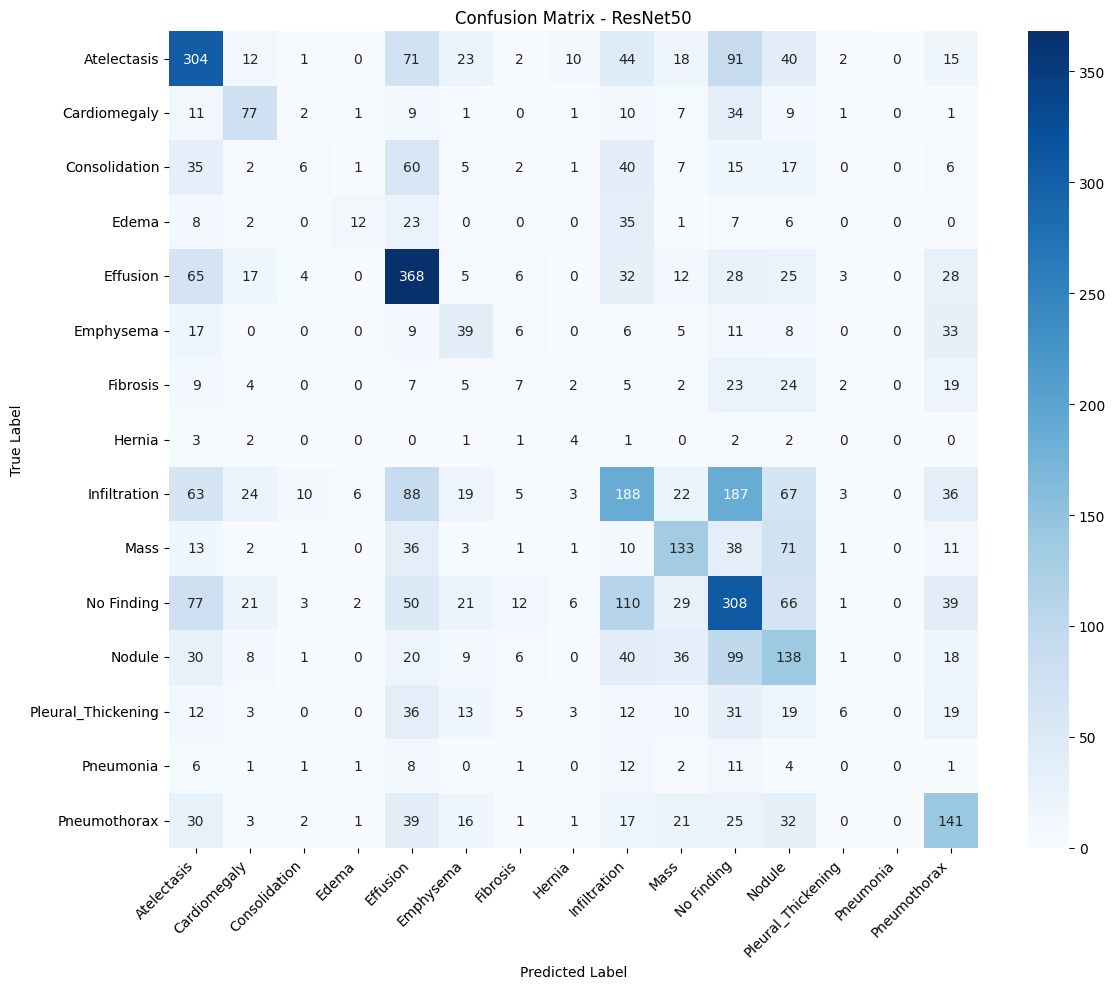

In [21]:
# ------------------------------------------------------------------------------
# VISUALIZE RESULTS
# Generate and save confusion matrix heatmap for model performance analysis
# ------------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[class_mapping[i] for i in range(NUM_CLASSES)],
            yticklabels=[class_mapping[i] for i in range(NUM_CLASSES)])
plt.title('Confusion Matrix - ResNet50')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_resnet50.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved to 'confusion_matrix_resnet50.png'")

Testing on: data/test\Atelectasis\00012322_008.png

Top 5 Predictions:
--------------------------------------------------
1. Effusion                  - 22.65%
2. No Finding                - 18.16%
3. Atelectasis               - 16.62%
4. Infiltration              - 7.84%
5. Consolidation             - 6.77%


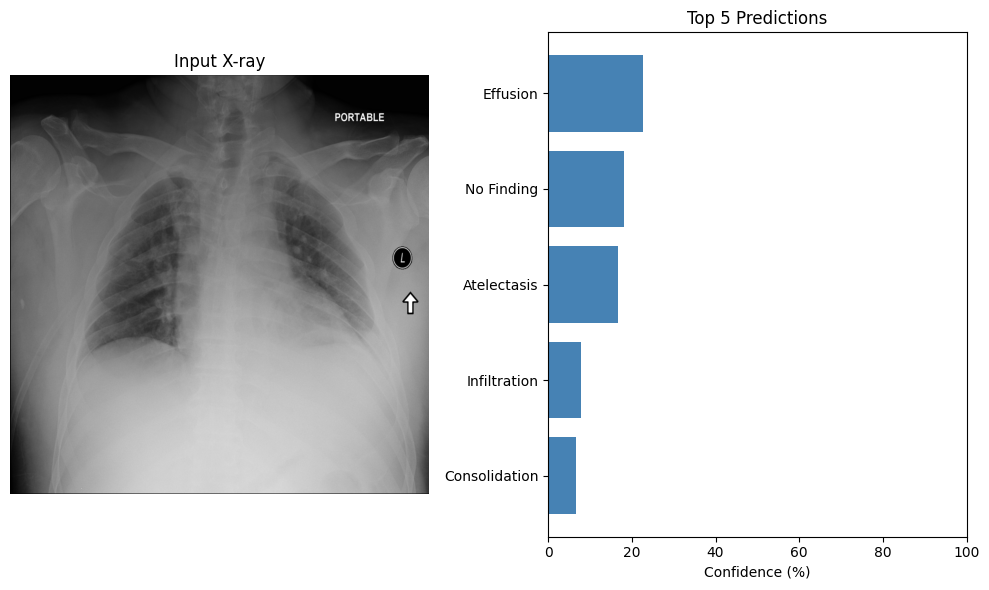

In [23]:
# ------------------------------------------------------------------------------
# INFERENCE ON SINGLE IMAGE
# Test the trained model on a new chest X-ray image
# ------------------------------------------------------------------------------

def predict_image(image_path, model, device, transform, class_mapping, top_k=3):
    """
    Predict disease class for a single chest X-ray image
    
    Args:
        image_path: Path to the image file
        model: Trained PyTorch model
        device: torch device (cuda/cpu)
        transform: Image transforms
        class_mapping: Dictionary mapping class indices to disease names
        top_k: Number of top predictions to return
    
    Returns:
        predictions: List of (disease_name, probability) tuples
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probabilities, top_k)
    
    # Format results
    predictions = []
    for prob, idx in zip(top_probs[0], top_indices[0]):
        disease_name = class_mapping[idx.item()]
        predictions.append((disease_name, prob.item()))
    
    return image, predictions


# Example usage: Test on a random image from test set
import random

# Get a random test image
test_image_path = random.choice(test_dataset.image_paths)
print(f"Testing on: {test_image_path}\n")

# Make prediction
original_image, predictions = predict_image(
    test_image_path, 
    model, 
    device, 
    eval_transform,  # Use eval_transform (no augmentation for inference)
    class_mapping, 
    top_k=5
)

# Display results
print("Top 5 Predictions:")
print("-" * 50)
for i, (disease, prob) in enumerate(predictions, 1):
    print(f"{i}. {disease:25} - {prob*100:.2f}%")

# Visualize
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title(f'Input X-ray')
plt.axis('off')

plt.subplot(1, 2, 2)
diseases = [pred[0] for pred in predictions]
probs = [pred[1] * 100 for pred in predictions]
plt.barh(diseases, probs, color='steelblue')
plt.xlabel('Confidence (%)')
plt.title('Top 5 Predictions')
plt.xlim(0, 100)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()